In [1]:
import cv2
import os
import shutil
import random
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf

2023-11-19 15:31:15.381786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [4]:
 # gestion du gpu
gpus =tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [6]:
# Chemins
IMAGE_POS = os.path.join('data', 'positive')
IMAGE_NEG = os.path.join('data', 'negative')
SELFIE = os.path.join('data', 'selfie')

# Liste des dossiers
folders = [IMAGE_POS, IMAGE_NEG, SELFIE]

# Supprimer le contenu des dossiers existants
for folder in folders:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

# Maintenant, les dossiers sont vides ou créés s'ils n'existent pas



In [130]:
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(IMAGE_NEG, file)
#         shutil.copy(EX_PATH, NEW_PATH)

In [8]:
# identifiant unique 
import uuid

In [10]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    frame_height, frame_width, _ = frame.shape
    roi_size = 250
    roi_margin = 20  # Marge autour de la ROI

    # Calcul des coordonnées pour centrer la ROI avec une marge
    roi_y = max(0, (frame_height - roi_size) // 2 - roi_margin)
    roi_x = max(0, (frame_width - roi_size) // 2 - roi_margin)

    # Extraction de la ROI centrée avec la marge
    frame_roi = frame[roi_y:roi_y + roi_size + 2 * roi_margin, roi_x:roi_x + roi_size + 2 * roi_margin, :]

    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(SELFIE, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame_roi)

    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(IMAGE_POS, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame_roi)

    cv2.imshow('Image Collection', frame_roi)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


: 

In [133]:
# def data_aug(img):
#     data = []
#     for i in range(9):
#         augmented_img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1, 2))
#         augmented_img = tf.image.stateless_random_contrast(augmented_img, lower=0.6, upper=1, seed=(1, 3))
#         # augmented_img = tf.image.stateless_random_crop(augmented_img, size=(20, 20, 3), seed=(1, 2))
#         augmented_img = tf.image.stateless_random_flip_left_right(augmented_img, seed=(np.random.randint(100), np.random.randint(100)))
#         augmented_img = tf.image.stateless_random_jpeg_quality(augmented_img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100), np.random.randint(100)))
#         augmented_img = tf.image.stateless_random_saturation(augmented_img, lower=0.9, upper=1, seed=(np.random.randint(100), np.random.randint(100)))

#         data.append(augmented_img)

#     return data

In [134]:
# for file_name in os.listdir(SELFIE):
#     img_path = os.path.join(SELFIE, file_name)
    
#     # Read the image using cv2.imread
#     img = cv2.imread(img_path)

#     # Check if the image is loaded successfully
#     if img is not None:

#         augmented_images = data_aug(img)
#         for image in augmented_images:
#             cv2.imwrite(os.path.join(SELFIE, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [135]:
# for file_name in os.listdir(os.path.join(IMAGE_POS)):
#     img_path = os.path.join(IMAGE_POS, file_name)
#     img = cv2.imread(img_path)

#     if img is not None: 
#         augmented_images = data_aug(img)

#         for image in augmented_images:
#             cv2.imwrite(os.path.join(IMAGE_POS, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [199]:
# PREPROCESSING
num_selfie = len(os.listdir(SELFIE))
num_positive = len(os.listdir(IMAGE_POS))
num_negative = len(os.listdir(IMAGE_NEG))

selfie_pattern = os.path.join(SELFIE, '*.jpg')
positive_pattern = os.path.join(IMAGE_POS, '*.jpg')
negative_pattern = os.path.join(IMAGE_NEG, '*.jpg')


selfie = tf.data.Dataset.list_files(selfie_pattern).take(num_selfie)
positive = tf.data.Dataset.list_files(positive_pattern).take(num_positive)
negative = tf.data.Dataset.list_files(negative_pattern).take(num_negative)

In [200]:
dir_test = selfie.as_numpy_iterator()
print(dir_test.next())

b'data/selfie/f7ebfeea-85ad-11ee-aa60-acde48001122.jpg'


In [382]:
# RESCALE

def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
     
    img = tf.io.decode_jpeg(byte_img)
   
    img = tf.image.resize(img, (105,105))
    
    img = img / 255.0

    
    return img

In [204]:
img = preprocess(dir_test.next())
img.numpy().max()

0.99028283

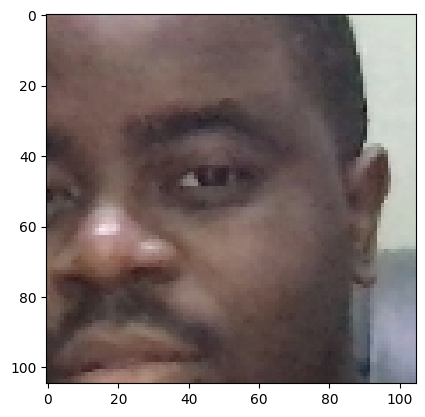

In [205]:
plt.imshow(img)

In [206]:
# CRETAION DES TRIPLETS 

positives = tf.data.Dataset.zip((selfie, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(selfie)))))
negatives = tf.data.Dataset.zip((selfie, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(selfie)))))
data = positives.concatenate(negatives)

In [207]:
exemple = data.as_numpy_iterator()

In [208]:
exemples =exemple.next()
print(exemples)

(b'data/selfie/beaad63c-85a9-11ee-aa60-acde48001122.jpg', b'data/positive/403bc450-85ae-11ee-aa60-acde48001122.jpg', 1.0)


In [209]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [210]:
res = preprocess_twin(*exemples)

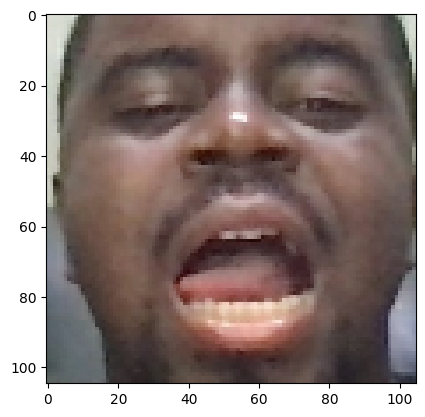

In [211]:
plt.imshow(res[1])

In [212]:
res[2]

1.0

In [213]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [214]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [215]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# LE MODELE 

In [216]:
inp = Input(shape=(105,105,3), name='input_image')

In [217]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [218]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [219]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [220]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [221]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [222]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [223]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 21, 21, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 18, 18, 128)       26

In [224]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
 
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [225]:
embedding = make_embedding()

In [226]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 21, 21, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 18, 18, 128)       26

# CALCUL DE DISTANCE

In [227]:

class L1Dist(Layer):
    
    
    def __init__(self, **kwargs):
        super().__init__()
       
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# iFace_Pass MODELE

In [228]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

In [229]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [232]:
siamese_layer = L1Dist()

In [233]:
distances = siamese_layer(inp_embedding, val_embedding)

In [234]:
classifier = Dense(1, activation='sigmoid')(distances)

In [235]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_14')>

In [237]:
iface_pass = Model(inputs=[input_image, validation_image], outputs=classifier, name='iFace_Pass')

In [238]:
iface_pass.summary()

Model: "iFace_Pass"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                         

In [239]:
def make_iface_pass_model(): 
    
    
    input_image = Input(name='input_img', shape=(105,105,3))
    
    
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
   
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='iFace_Pass')

In [240]:
iface_pass = make_iface_pass_model()

In [241]:
iface_pass.summary()

Model: "iFace_Pass"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                         

# ENTRAINEMENT

## OPTIMIZER-LOSS FUNCTION

In [242]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [244]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## ETABLIR UN CHECKPOINT

In [245]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=iface_pass)

## FONCTION D'ENTRAINEMENT

In [246]:
test_batch = train_data.as_numpy_iterator()

In [247]:
batch_1 = test_batch.next()

In [248]:
X = batch_1[:2]

In [250]:
y = batch_1[2]

In [251]:
y

array([1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

In [253]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = iface_pass(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
  
    grad = tape.gradient(loss, iface_pass.trainable_variables)
    
   
    opt.apply_gradients(zip(grad, iface_pass.trainable_variables))
        
    
    return loss

In [254]:

from tensorflow.keras.metrics import Precision, Recall

In [255]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# ENTRAINEMENT DU MODELE

In [256]:
EPOCHS = 50


In [ ]:
train(train_data, EPOCHS)


In [262]:
from tensorflow.keras.metrics import Precision, Recall

In [286]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [287]:
y_hat = iface_pass.predict([test_input, test_val])

1/1 [==============================] - 1s 906ms/step


In [288]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]

In [289]:
y_true

array([1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

In [290]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.75

In [291]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = iface_pass.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 621ms/step
0.6764706 0.44296297


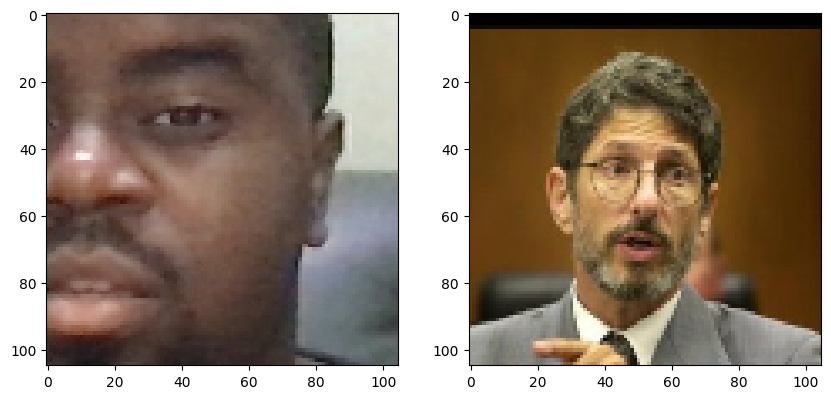

In [292]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [344]:
L1Dist

__main__.L1Dist

In [357]:
iface_pass_model = tf.keras.models.load_model('iface_passv2.h5', 
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [358]:
iface_pass_model.predict([test_input, test_val])

1/1 [==============================] - 1s 612ms/step


array([[1.31260196e-03],
       [6.58236195e-06],
       [1.00000000e+00],
       [4.89139522e-04],
       [9.99904513e-01],
       [9.99944210e-01],
       [6.86919819e-08],
       [1.09362896e-04]], dtype=float32)

In [359]:
iface_pass_model.summary()

Model: "iFace_Pass"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                         

In [360]:
os.listdir(os.path.join('application_data', 'verification_images'))

['3a5510d2-85ae-11ee-aa60-acde48001122.jpg',
 '0fc0b942-85aa-11ee-aa60-acde48001122.jpg',
 '3cf72a96-85ae-11ee-aa60-acde48001122.jpg',
 '43553176-85ae-11ee-aa60-acde48001122.jpg',
 '4947190a-85ae-11ee-aa60-acde48001122.jpg',
 '.DS_Store',
 '3ce2277c-85ae-11ee-aa60-acde48001122.jpg',
 '3ac1a396-85ae-11ee-aa60-acde48001122.jpg',
 '4999739e-85ae-11ee-aa60-acde48001122.jpg',
 '3b455fce-85ae-11ee-aa60-acde48001122.jpg',
 '3a30f1d4-85ae-11ee-aa60-acde48001122.jpg',
 '3b02c1c8-85ae-11ee-aa60-acde48001122.jpg',
 '43127976-85ae-11ee-aa60-acde48001122.jpg',
 '4753051e-85ae-11ee-aa60-acde48001122.jpg',
 '2a5d51f2-85aa-11ee-aa60-acde48001122.jpg',
 '4483668a-85ae-11ee-aa60-acde48001122.jpg',
 '44002680-85ae-11ee-aa60-acde48001122.jpg',
 '3eecf358-85ae-11ee-aa60-acde48001122.jpg',
 '3ce2720e-85ae-11ee-aa60-acde48001122.jpg',
 '3a69eae2-85aa-11ee-aa60-acde48001122.jpg',
 '2a2a7926-85aa-11ee-aa60-acde48001122.jpg',
 '3b6f90b4-85ae-11ee-aa60-acde48001122.jpg',
 '3ac16e9e-85ae-11ee-aa60-acde48001122.jp

In [361]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [362]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/3a5510d2-85ae-11ee-aa60-acde48001122.jpg
application_data/verification_images/0fc0b942-85aa-11ee-aa60-acde48001122.jpg
application_data/verification_images/3cf72a96-85ae-11ee-aa60-acde48001122.jpg
application_data/verification_images/43553176-85ae-11ee-aa60-acde48001122.jpg
application_data/verification_images/4947190a-85ae-11ee-aa60-acde48001122.jpg
application_data/verification_images/.DS_Store
application_data/verification_images/3ce2277c-85ae-11ee-aa60-acde48001122.jpg
application_data/verification_images/3ac1a396-85ae-11ee-aa60-acde48001122.jpg
application_data/verification_images/4999739e-85ae-11ee-aa60-acde48001122.jpg
application_data/verification_images/3b455fce-85ae-11ee-aa60-acde48001122.jpg
application_data/verification_images/3a30f1d4-85ae-11ee-aa60-acde48001122.jpg
application_data/verification_images/3b02c1c8-85ae-11ee-aa60-acde48001122.jpg
application_data/verification_images/43127976-85ae-11ee-aa60-acde48001122.jpg
application_data/

In [384]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [386]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame_height, frame_width, _ = frame.shape
    roi_size = 250

    # Calcul des coordonnées pour centrer la ROI
    roi_y = (frame_height - roi_size) // 2
    roi_x = (frame_width - roi_size) // 2

    # Extraction de la ROI centrée
    frame = frame[roi_y:roi_y + roi_size, roi_x:roi_x + roi_size, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):


        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(iface_pass_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

InvalidArgumentError: Graph execution error:

Detected at node iFace_Pass/embedding/dense_1/BiasAdd_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/var/folders/8d/df4t0zt52_19w78x9yzz4_nw0000gn/T/ipykernel_55878/3774807659.py", line 24, in <module>

  File "/var/folders/8d/df4t0zt52_19w78x9yzz4_nw0000gn/T/ipykernel_55878/139549914.py", line 9, in verify

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2655, in predict

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/jamesolongo/Documents/Institut Saint Jean/Master 2/1er Semestre/Machine Learning/Siamens/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 252, in call

Matrix size-incompatible: In[0]: [1,160000], In[1]: [9216,4096]
	 [[{{node iFace_Pass/embedding/dense_1/BiasAdd_1}}]] [Op:__inference_predict_function_41401]

: 

In [305]:
np.sum(np.squeeze(results) > 0.9)

NameError: name 'results' is not defined